# Desafio (Parte 2) - Recomendação de Produtos

## Case baseado no desafio do Kaggle: "Instacart Market Basket Analysis"

Esse desafio é baseado em uma competição do Kaggle ([https://www.kaggle.com](https://www.kaggle.com)) de 2017, onde é pedido para fazer a predição de se um produto será comprado por dado usuário no carrinho atual, baseado em suas compras anteriores.

Link para o desafio: [https://www.kaggle.com/c/instacart-market-basket-analysis](https://www.kaggle.com/c/instacart-market-basket-analysis)

## Origem dos Dados:

Os dados mostrados nesse desafio são uma amostra extraída do dataset disponibilizado gratuitamente pela empresa Instacart ([https://www.instacart.com/](https://www.instacart.com/)) **\***. São dados reais do banco de dados da empresa, que foram anonimizados para o uso por pesquisadores e em competições de Data Science.

 
###### * “The Instacart Online Grocery Shopping Dataset 2017”, Accessed from [https://www.instacart.com/datasets/grocery-shopping-2017](https://www.instacart.com/datasets/grocery-shopping-2017) on March 10, 2017.

___

# Imports

In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
""" habilitando plots no notebook """
%matplotlib inline

In [3]:
""" plot libs """
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
""" Configurando o Matplotlib para o modo manual """
plt.interactive(False)

# Objetivo :

Analisar o dataset (o mesmo construído na Aula 07) e responder às questões em cada item usando gráficos.

# Importante:

Todos os gráficos devem conter:
* Título
* Rótulos do Eixo X e do Eixo Y

Se mais de um gráfico for plotado em uma única janela, eles devem ter:
* Cores diferentes
* Legenda
* Transparência (na sobreposição)

# Dataset:

O dataset utilizado nesse desafio é um sub-conjunto daquele construído na Aula 7. Para essa aula, será necessário carregar apenas duas colunas: `user_id` e `product_name`.

## Carregando os dados

In [5]:
""" Nota sobre o Warning: 
    O código abaixo levanta um Warning gerado por uma chamada interna do pandas conflitando com o Numpy.
    Não há necessidade de tratar esse Warning no momento, o comportamento do 'read_csv' é funcional para o que queremos.
"""
dataset = pd.read_csv(
    os.path.join("data", "dataset.csv"),
    usecols=["user_id", "product_name"],
    sep=",",
    index_col=0,
    encoding="utf-8"
)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Extração dos dados específicos

In [6]:
product_count = dataset.groupby("user_id").product_name.count()

In [7]:
product_count.describe()

count    114885.000000
mean         10.568394
std           7.946615
min           1.000000
25%           5.000000
50%           9.000000
75%          14.000000
max          80.000000
Name: product_name, dtype: float64

In [8]:
product_count.head(10)

user_id
1     11
2     31
5      9
7      9
8     18
9     22
10     4
13     5
14    11
17     6
Name: product_name, dtype: int64

# Problemas

## Conceito: Recomendação Simples de Produtos

Um sistema de recomendação bem rudimentar pode ser construído usando a teoria de [`Collaborative Filtering`](https://en.wikipedia.org/wiki/Collaborative_filtering). 

Na figura abaixo está mostrado um exemplo simples:

![Collaborative Filtering](images/Collaborative_filtering.gif)

A idéia principal é representar um `usuário` pelo seu `perfil de compras`, ou seja, o usuário será representado por **todos os produtos** que ele já comprou.

## Construção do Dataset

Como serão usados métodos computacionais muito pesados, será necessário reduzir bastante a quantidade de dados utilizados. Dessa forma, serão usados apenas os **1% dos dados de usuários que compraram mais produtos** do dataset.

### Selecionando os usuários

In [9]:
product_count.describe(percentiles=[.1, .25, .5, .75, .99])

count    114885.000000
mean         10.568394
std           7.946615
min           1.000000
10%           2.000000
25%           5.000000
50%           9.000000
75%          14.000000
99%          37.000000
max          80.000000
Name: product_name, dtype: float64

In [10]:
selected = product_count[product_count >= 37].index
selected.shape

(1194,)

In [11]:
dataset.loc[selected].shape

(51439, 1)

In [12]:
dataset.loc[selected].head()

,product_name
user_id,
238,Lunchables Turkey & American Cheese with Crackers
238,Light Red Raspberry Yogurt
238,Farmhouse Hearty White Bread
238,Lunchables Turkey & American Cheese Cracker St...
238,Strawberry Banana


### Criando a Tabela de Ocorrências

Uma `Tabela de Ocorrências` relaciona quantos produtos um usuário comprou **para cada produto**. 

Exemplo:

a) Dado Original:

| user_id | product_name  |
|:------- |:------------- |
| 12345   | Ground Coffee |
| 12345   | White Sugar   |
| 12345   | Bread         |
| 67890   | Ground Coffee |
| 67890   | A Type Milk   |
| 67890   | Vodka         |
| 67890   | Fudge Brownie |

b) Tabela de Ocorrências:

| user_id | Ground Coffee | White Sugar   | Bread         | A Type Milk   | Vodka         | Fudge Brownie |
|:------- |:------------- |:------------- |:------------- |:------------- |:------------- |:------------- |
| 12345   | 1             | 1             | 1             | 0             | 0             | 0             |
| 67890   | 1             | 0             | 0             | 1             | 1             | 1             |




In [15]:
temp = dataset.loc[selected].reset_index()
users = temp.user_id
prods = temp.product_name

In [19]:
user_prod = pd.crosstab(users, prods)
user_prod.head()

product_name,& Go! Hazelnut Spread + Pretzel Sticks,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Greek Yogurt Black Cherry on the Bottom,0% Fat Vanilla Greek Yogurt,0% Greek Strained Yogurt,0% Greek Yogurt Black Cherry on the Bottom,"0% Greek, Blueberry on the Bottom Yogurt",1 % Lowfat Milk,1 Apple + 1 Mango Fruit Bar,...,from Concentrate Mango Nectar,gelato Coffee Toffee,in 100% Juice Mixed Fruit,of Hanover 100 Calorie Pretzels Mini,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,with Crispy Almonds Cereal,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing,with Sweet & Smoky BBQ Sauce Cheeseburger Sliders
user_id,,,,,,,,,,,,,,,,,,,,,
238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
375,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
user_prod.shape

(1194, 12962)

### Redução de Dimensionalidade

A `Tabela de Ocorrências` é uma matriz muito grande e muito **esparsa**, i.e. possui muitas colunas e pouca informação. Por pouca informação pode-se entender que menos de 1% da matriz é composta por elementos **não zeros**.

Para esse tipo de dado, em que é necessária muita memória e processamento para se extrair informações relevantes, usam-se técnicas de **redução de dimensionalidade**. Essas técnicas têm como objetivo condensar (ou mesmo comprimir) a informação esparsa em uma representação muito menor e densa.

Nesse desafio será utilizado a técnica linear de extração de componentes principais, ou `Principal Component Analysis` (`PCA`). Para saber mais sobre essa ferramenta, veja os links abaixo:

- [Teoria do PCA (Wikipédia)](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [Implementação do Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

A figura abaixo mostra um exemplo de PCA aplicado a um conjunto de dados de 2 variáveis (`x` e `y`). Pode-se observar que os novos eixos encontrados descrevem muito mais facilmente a distribuição de dados do que os eixos de `x` e `y` originais.

![GaussianScatterPCA](images/GaussianScatterPCA.svg)


Sem entrar muito em detalhes técnicos de implementação do PCA, essa técnica descorrelaciona (torna **linearmente independentes**) os dados originais e os ordena do mais importante (i.e. aquele que carrega **mais informação**) para o menos; com isso, pode-se escolher manter apenas as nosvas dimensões que **melhor explicam** os dados e jogar fora o resto. 

Nesse desafio, vamos reduzir a tabela de dados das `12.962` colunass originais para apenas `100` usando a implementação de PCA do `scikit-learn`. 

In [20]:
from sklearn.decomposition import PCA

user_prod_pca = pd.DataFrame(
    index=user_prod.index,
    data=PCA(100).fit_transform(user_prod)
)
user_prod_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
238,-0.976656,-0.564292,-0.190321,0.136242,-0.043516,-0.137875,-0.196980,-0.070500,-0.235119,0.105420,...,-0.112286,-0.315834,0.001419,-0.493583,-0.312823,-0.880739,-0.037247,0.037327,0.390226,0.642536
375,-0.127334,-0.063304,0.092099,0.726938,-1.127571,-0.314743,0.005641,-0.335140,-0.608947,0.286338,...,-0.082265,-0.225968,0.086567,0.357653,0.382082,-0.041977,-0.121188,0.217930,-0.077763,-0.015219
863,1.093155,-0.430331,-0.195158,0.505877,-1.103690,0.436700,-0.517774,0.883143,-0.665443,-0.349872,...,0.030206,0.156985,0.183140,-0.241374,0.417166,-0.606682,-0.279163,0.016720,0.372538,-0.100060
890,0.863729,-0.164227,-0.143020,0.383533,0.202249,-0.539539,-0.421926,-0.292201,0.473515,0.302282,...,-0.108647,0.239853,-0.213731,0.328930,-0.202317,-0.241266,0.200134,0.289885,0.103538,-0.007328
982,-0.166054,0.229981,0.808879,0.127154,-0.530928,-0.489014,0.070035,0.187692,0.346253,-0.042415,...,0.046403,-0.431027,0.430736,-0.290627,-0.095561,-0.140965,-0.103791,0.399593,0.661265,-0.276525


Para toda a Parte 2 do desafio, será usada a tabela gerada por PCA `user_prod_pca`. 

## A) Visualização e Seleção dos Usuários

Como o PCA ordena as _features_ da mais importante para a menos importante, as duas primeiras colunas da tabela `user_prod_pca` podem ser usadas para visualização dos usuários do sistema. 

Como temos muitos usuários ainda (`1.194`), será necessário escolher alguns poucos para observar a `similaridade` entre eles.   



### A.1) Visualização

Crie um `scatter plot` que mostra a representação 2D de todos os usuários em `user_prod_pca` usando as colunas `0` para  o eixo `x` e a coluna `1` para o eixo `y`. 

Esse gráfico deve ter as seguintes características:
* Tamanho da Figura: 15 x 15
* Título e Rótulos para os eixos X e Y
* Tamanho do símbolo no mínimo igual a 60
* Transparência, para verificar dados que eventualmente se sobreponham.

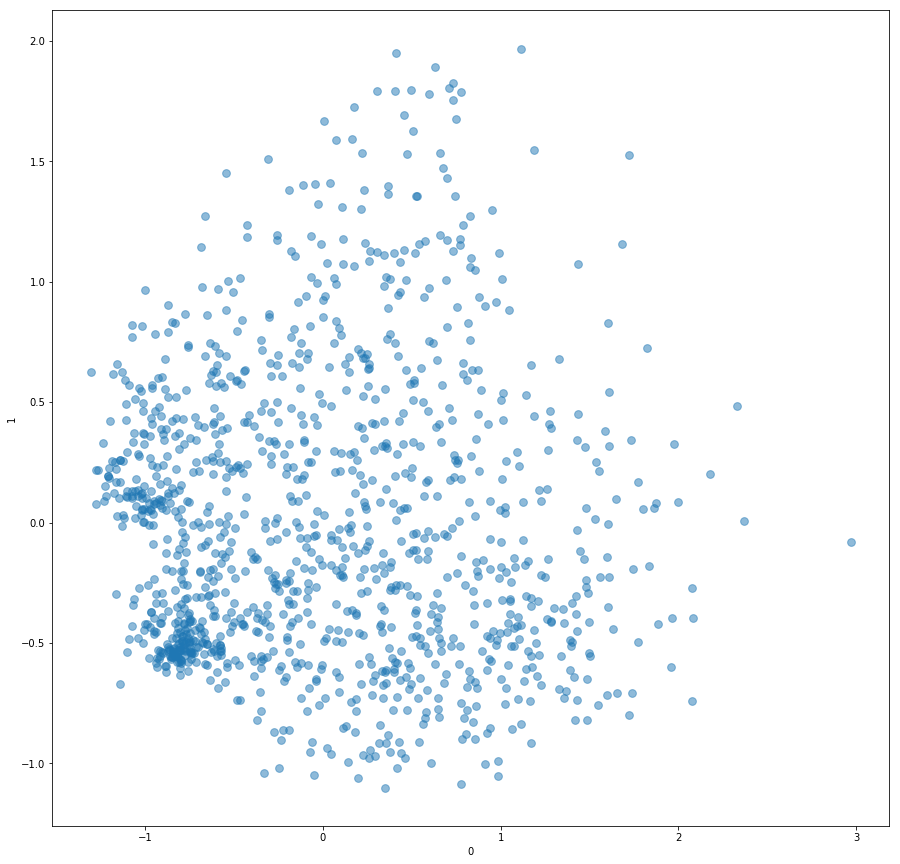

In [27]:
""" Escreva a a Solução Aqui """    
plt.figure(figsize=(15, 15))
plt.scatter(user_prod_pca[0], 
            user_prod_pca[1], 
            s=60,
           alpha=0.5)
plt.xlabel('0')
plt.ylabel('1')
plt.show()

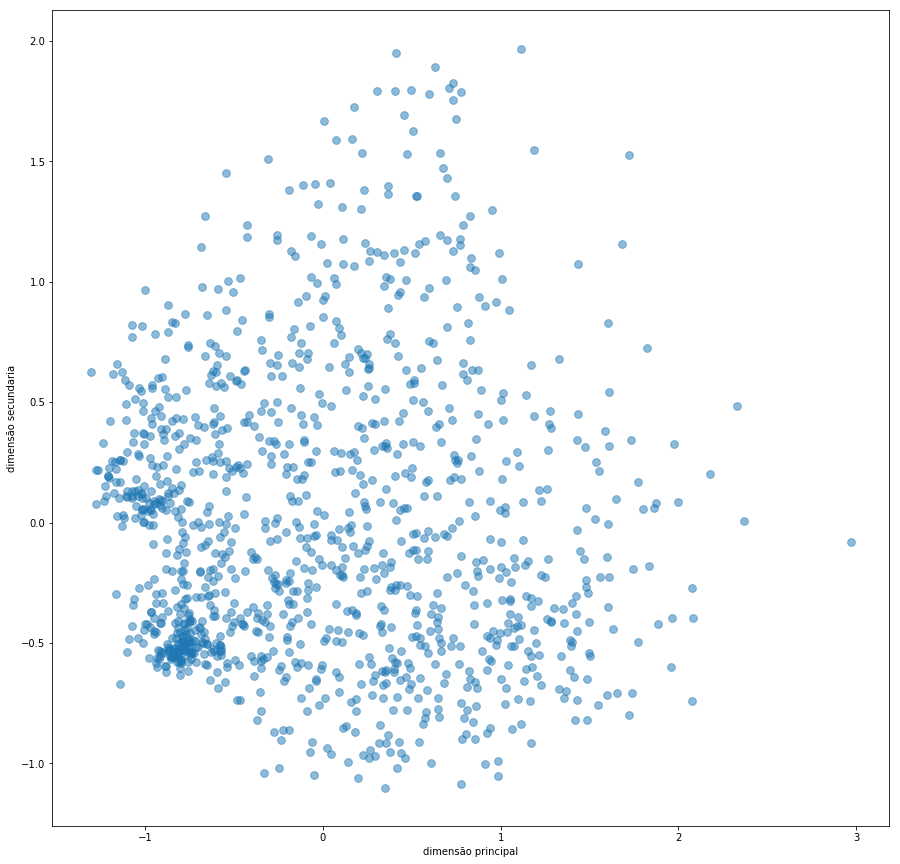

In [29]:
user_prod_pca.plot(kind="scatter",
                  x=0, y=1,
                  figsize=(15,15),
                  alpha=0.5,
                  s=60)
plt.xlabel("dimensão principal")
plt.ylabel("dimensão secundaria")

plt.show()

### A.2) Seleção

Crie outro `scatter plot` que mostra apenas uma parte do domínio onde há uma maior concentração de usuários; esse gráfico será parecido com um **zoom** nessa parte do domínio. 

Sugestão do corte:
- `-0.7 < X < -0.5`
- `-0.6 < Y < -0.4`

Esse gráfico deve ter as mesmas características do anterior e ainda mostrar, para cada usuário, o texto contendo seu `user_id`.

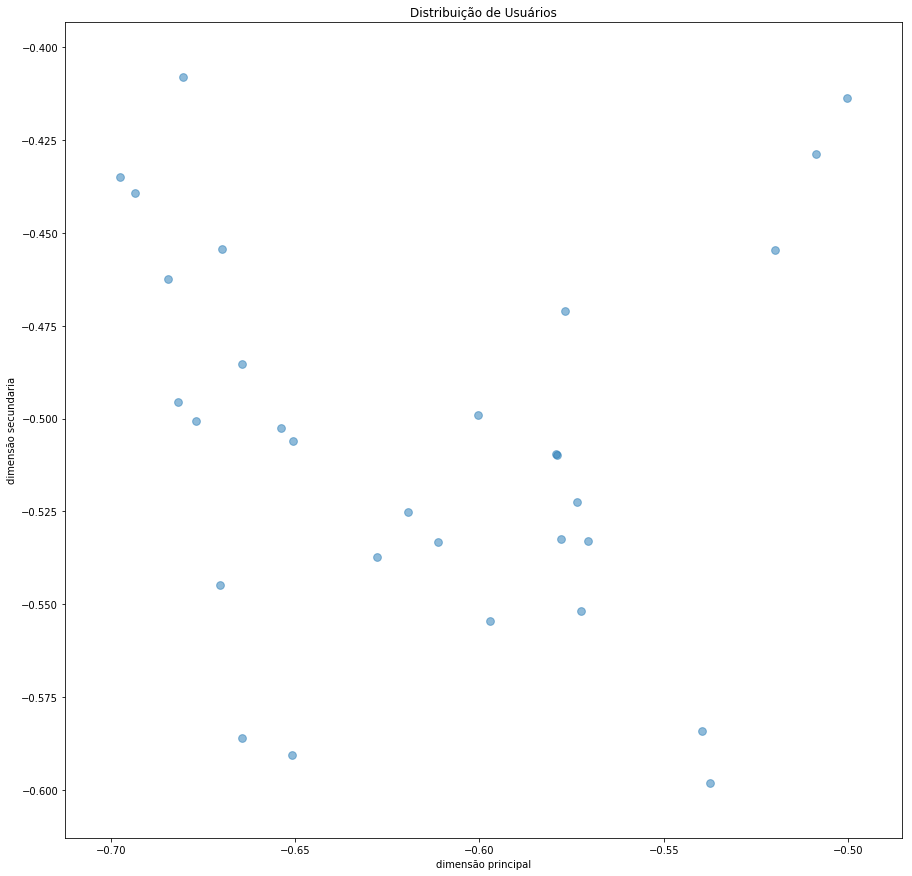

In [53]:
user_prod_pca_sliced = user_prod_pca[  (user_prod_pca[0]> -0.7) 
                                     & (user_prod_pca[0]< -0.5) 
                                     & (user_prod_pca[1]> -0.6) 
                                     & (user_prod_pca[1]< -0.4)]
# """ Escreva a a Solução Aqui """ 
user_prod_pca_sliced.plot(kind="scatter",
                  x=0, y=1,
                  figsize=(15,15),
                  alpha=0.5,
                  s=60)
plt.xlabel("dimensão principal")
plt.ylabel("dimensão secundaria")
plt.title("Distribuição de Usuários")

# user_prod_pca_sliced.shape
plt.show()


In [54]:
""" Modo do Professor"""
index =  (user_prod_pca[0] > -0.7) & (user_prod_pca[0] < -0.5)
index &= (user_prod_pca[1] > -0.6) & (user_prod_pca[1] < -0.4)

user_prod_pca_slice = user_prod_pca.loc[index]
user_prod_pca_slice.shape

(30, 100)

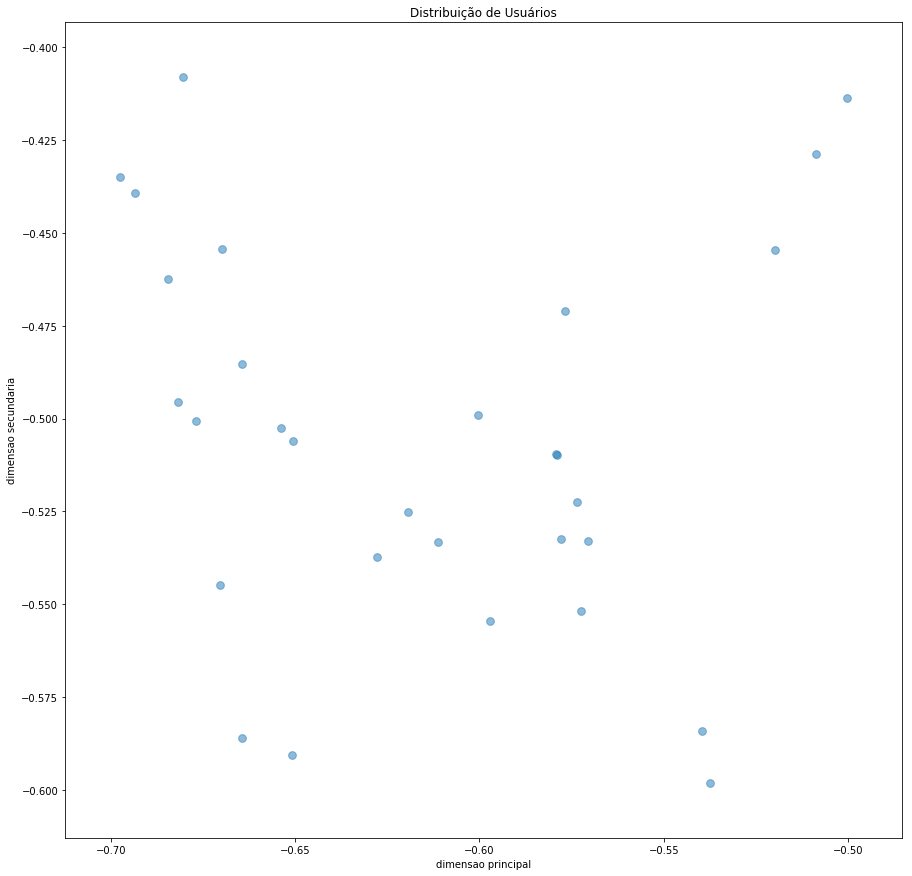

In [58]:
user_prod_pca_slice.plot(
    kind="scatter", 
    x=0, y=1, 
    figsize=(15, 15),
    alpha=0.5, 
    s=60
)

plt.xlabel("dimensao principal")
plt.ylabel("dimensao secundaria")
plt.title("Distribuição de Usuários")

plt.show()

## B) Similaridade usando Correlação entre Usuários

Para saber se um usuário é `similar` a outro, pode-se utilizar várias métricas de similaridade. Como o método de redução de dimensionalidade escolhido é linear, pode-se usar o `coeficiente de correlação de Pearson` entre as representações de dimensão `100` dos usuários como métrica de similaridade. Para saber mais sobre a correlação de Pearson, veja [este link da Wikipédia](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

A interpretação do coeficiente `r` como métrica de similaridade é a seguinte:
* Se `|r|` é próximo de `1`, os elementos são **muito similares**;
* Se `|r|` é próximo de `0`, os elementos são **muito diferentes**.


### B.1) Visualização da Correlação

Selecione `10` usuários do `item A`, dentre próximos e distantes, e visualize a `correlação` entre todos eles.

Dica 1: use um método que mostre a correlação de todos contra todos em vez de criar uma visualização para cada dupla.

Dica 2: A maioria das funções de correlação enxergam os dados por coluna em vez de linhas; tente transpor a sua matriz caso o resultado esteja estranho. 

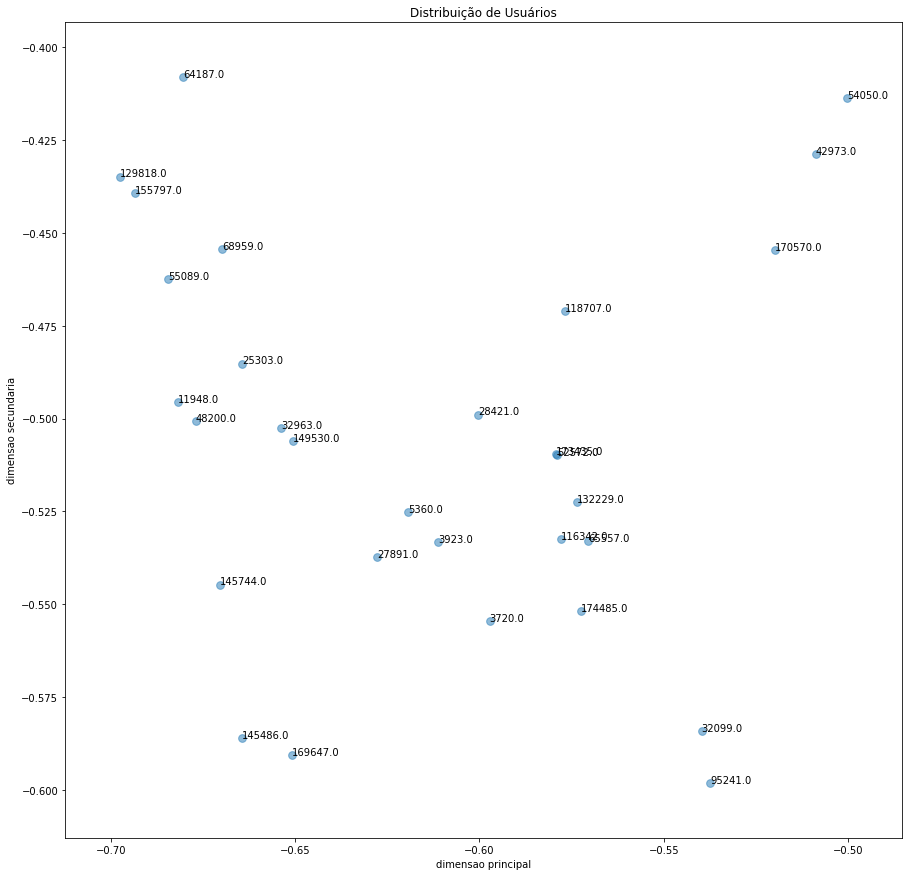

In [66]:
user_prod_pca_slice.plot(
    kind="scatter", 
    x=0, y=1, 
    figsize=(15, 15),
    alpha=0.5, 
    s=60
)

for s, x, y in user_prod_pca_slice.reset_index().values[:, :3]:
    plt.text(x, y, s=s)
    plt.scatter(x, y, s=0)

plt.xlabel("dimensao principal")
plt.ylabel("dimensao secundaria")
plt.title("Distribuição de Usuários")

plt.show()

In [67]:
""" Escreva a a Solução Aqui """    


' Escreva a a Solução Aqui '

### B.2) Verificando a Similaridade das Compras dos Usuários

Escolha dois usuários com uma correlação alta e verifique os produtos que ambos compraram. Faça o mesmo depois para usuários de correlação baixa.

In [ ]:
""" Escreva a a Solução Aqui """    